In [1]:
import os
import sys

import math
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
import torchvision.models as models

from torchviz import make_dot
import matplotlib.pyplot as plt
import graphviz

from pathlib import Path
from userHelper import *


# Model Specifics
# import pytorch_resnet as R
import BaseModel as B
import CDDSM



#Device Selection
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
num_epochs = 5
num_classes = 3
batch_size = 4
learning_rate = 0.001

def pause(strg):
    if(strg!=''):
        print('Reached at {}, Press any key to continue'.format(strg))
    else:
        print('Paused, Press any to continue')
    input()
    return

# x = torch.randn(batch_size, channels_mammo,heights_mammo , width_mammo)

# Reading Standard CSV files by TCIA for test/train

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

num_epochs = 100
num_classes = 3
batch_size = 5
learning_rate = 0.0001

total_iteration = 10000
img_resize =H=W=512


homedir = str(Path.home())
homedir

train_df = CDDSM.createTrainFrame(homedir)
test_df = CDDSM.createTestFrame(homedir)
mammogram_dir = '/home/himanshu/CuratedDDSM/'
train_file = mammogram_dir+'train.csv'
test_file = mammogram_dir+'test.csv'
train_df.to_csv(train_file)
test_df.to_csv(test_file)

classes = ('BENIGN', 'BENIGN_WITHOUT_CALLBACK', 'MALIGNANT')
                

# Making of CBIS-DDSM Dataset (train,val,test)

In [3]:
dataset =  CDDSM.MammographyDataset(train_file,homedir,img_resize)
test_dataset = CDDSM.MammographyDataset(test_file,homedir,img_resize)

train_dataset , val_dataset = CDDSM.trainValSplit(dataset,val_share=0.1)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

# Length of each Dataset

In [4]:
numberOfTrainData = train_dataset.__len__()
numberOfValData = val_dataset.__len__()
numberOfTestData =  test_dataset.__len__()

total_step=len(train_loader)

print('Size of training dataset {}'.format(numberOfTrainData))
print('Size of Validation dataset {}'.format(numberOfValData))
print('Size of testing dataset {}'.format(numberOfTestData))
print('No. of Epochs: {}\n Batch size: {}\n Learning_rate : {}\n Image size {}*{}\n Step {}'
        .format(num_epochs,batch_size,learning_rate,H,W,total_step))

Size of training dataset 2577
Size of Validation dataset 287
Size of testing dataset 704
No. of Epochs: 100
 Batch size: 5
 Learning_rate : 0.0001
 Image size 512*512
 Step 516


# Checking images in each dataset by making grid

# trainDataset

MALIGNANT MALIGNANT BENIGN BENIGN


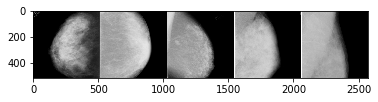

In [5]:
trainloader = train_loader
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# val Dataset

BENIGN_WITHOUT_CALLBACK BENIGN_WITHOUT_CALLBACK BENIGN BENIGN_WITHOUT_CALLBACK


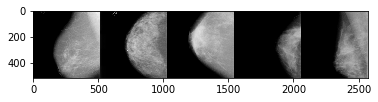

In [6]:
trainloader = val_loader
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# test Dataset

MALIGNANT MALIGNANT MALIGNANT MALIGNANT


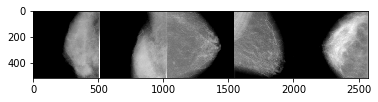

In [7]:
trainloader = test_loader
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Get Model

In [8]:
model = B.getModel(3).to(device)

# store best prediction in one epoch

best_prec = 0


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)


In [9]:
# See the architecture
print(model)

BaselineNet(
  (layer1): Sequential(
    (conv_1_1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_1_1): ReLU()
    (conv_1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (maxpool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (conv_2_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_2_1): ReLU()
    (conv_2_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (maxpool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (maxpool_3_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (conv_3_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (maxpool_3_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_3_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [10]:
print(criterion)

CrossEntropyLoss()


In [11]:
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)


# TensorBoard Logger

In [12]:
from tensorboardX import SummaryWriter
writer = SummaryWriter('runs',comment="baseline")

# Training

In [ ]:
for epoch in range(num_epochs):
    adjust_learning_rate(optimizer,epoch,learning_rate)
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    
    model.train()
    
    end=time.time()
    
    for i, (images,labels) in enumerate(train_loader):
        data_time.update(time.time()-end)
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        

In [ ]:
# # Reading a mammogram
# homedir = str(Path.home())
# homedir

# # CSV preprocessing
# train_df = CDDSM.createTrainFrame(homedir)
# test_df = CDDSM.createTestFrame(homedir)
# mammogram_dir = '/home/himanshu/CuratedDDSM/'
# train_file = mammogram_dir+'train.csv'
# test_file = mammogram_dir+'test.csv'
# train_df.to_csv(train_file)
# test_df.to_csv(test_file)

# # labells = train_df[['pathology','pathology_class']]
# # print(labells)


# classes = ('BENIGN', 'BENIGN_WITHOUT_CALLBACK', 'MALIGNANT')

# # Mammography dataset
# train_dataset =  CDDSM.MammographyDataset(train_file,homedir)
# test_dataset = CDDSM.MammographyDataset(test_file,homedir)
# # Data loader
# train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
#                                            batch_size=batch_size, 
#                                            shuffle=True)

# test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
#                                           batch_size=batch_size, 
#                                           shuffle=False)



In [ ]:
model = B.getModel(3).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

# Loss Function

In [ ]:
# loss function should be averaged summation of class loss (log loss)
# and normalized and weighted regression loss

output =  net(inputX)
groundTruth = torch.randn(10) #dummy target for now

In [ ]:
groundTruth = groundTruth.view(1,-1)

In [ ]:
groundTruth=groundTruth.reshape(1,10)

In [ ]:
defineLossfn = nn.MSELoss()
loss = defineLossfn(output,groundTruth)

In [ ]:
print(groundTruth.shape)
print(output.shape)
print(output.data)
print(groundTruth.data)
print(loss.data)

In [ ]:
print(loss.grad_fn)
a =  loss.grad_fn
print(a.next_functions[0][0])
a = a.next_functions[0][0]
print(a.next_functions[0][0])
a = a.next_functions[0][0]
print(a.next_functions[0][0])

In [ ]:
net.zero_grad() #zeroes the gradient buffers of all parameters
print(net.conv1.bias.grad)
print(net.conv2.bias.grad)
print(net.fc1.bias.grad)
print(net.fc2.bias.grad)
print(net.fc3.bias.grad)
for i in range(3):
    loss.backward(retain_graph=True,create_graph=True)
    print(net.conv1.bias.grad)
#     print(net.conv1.bias.grad)
#     print(net.conv2.bias.grad)
#     print(net.fc1.bias.grad)
#     print(net.fc2.bias.grad)
#     print(net.fc3.bias.grad)

In [ ]:
for i in range(3):
    loss.backward(retain_graph=True,create_graph=True)
    print(net.conv1.bias.grad)

In [ ]:
for i in range(3):
    loss.backward(retain_graph=True,create_graph=True)
    print(net.conv1.bias.grad)

# Updating the weights

In [ ]:
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data*learning_rate)

In [ ]:
# creating your optimizer
optimizer = optim.SGD(net.parameters(),lr=0.01)

# this should  be in training loop, how many iterations :
optimizer.zero_grad()
output = net(inputX)
loss = defineLossfn(output, groundTruth)
loss.backward()
optimizer.step()

In [ ]:
# #visualization  helper
# def vis_detections(im, dets, CONF_THRESH = 0.23):
#     """Draw boxes around detected cancer."""   
#     fig,ax=plt.subplots(figsize=(8,10))
#     ax.imshow(im,cmap='gray_r')
#     inds = np.where(dets[:, -1] >= CONF_THRESH)[0]
    
#     for i in inds:
#         bbox = dets[i, :4]
#         score = dets[i, -1]
#         ax.add_patch(
#             plt.Rectangle((bbox[0], bbox[1]),
#                           bbox[2] - bbox[0],
#                           bbox[3] - bbox[1], fill=False, linestyle ='dashed',
#                           edgecolor=(0.95, 0.95, 0.5), linewidth=3))
#     plt.axis('off')
#     plt.tight_layout()